In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

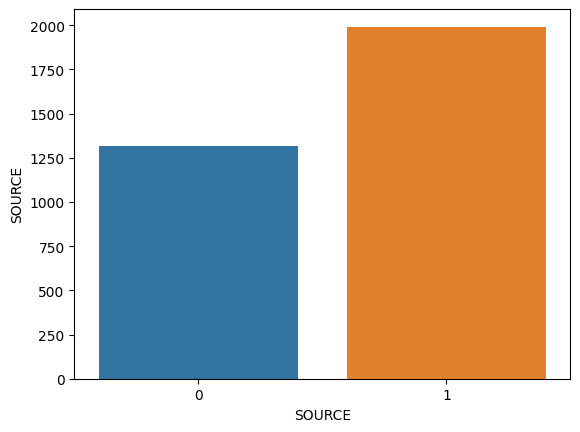

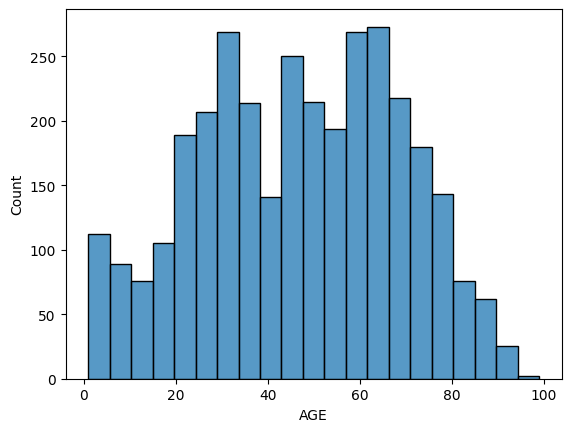

In [2]:
df = pd.read_csv('training_set.csv')
df.shape[0]
df.isna().sum()
classes = df['SOURCE'].value_counts()
sns.barplot(df, x='SOURCE',y=classes)
plt.show()
df['AGE'].value_counts()
sns.histplot(df, x='AGE')
plt.show()

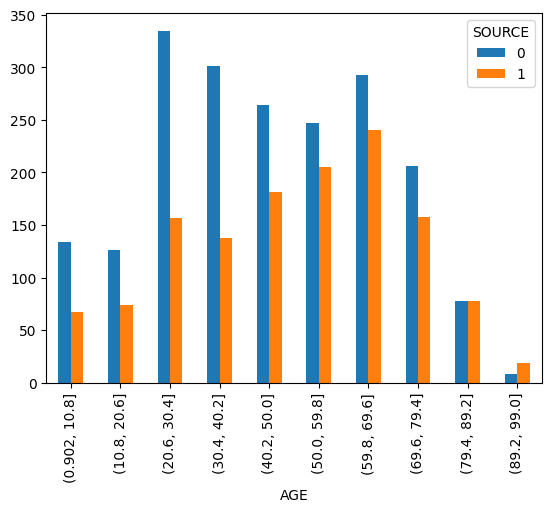

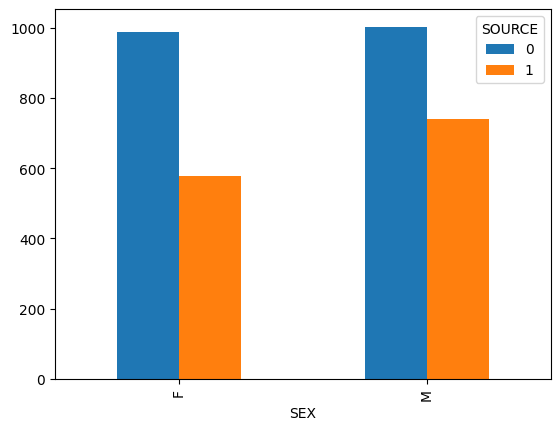

In [3]:
bin_age = df.copy()
bin_age['AGE'] = pd.cut(bin_age['AGE'],bins=10)
bin_age.groupby(['AGE', 'SOURCE']).size().unstack().plot.bar()
plt.show()
df.groupby(['SEX', 'SOURCE']).size().unstack().plot.bar()
plt.show()

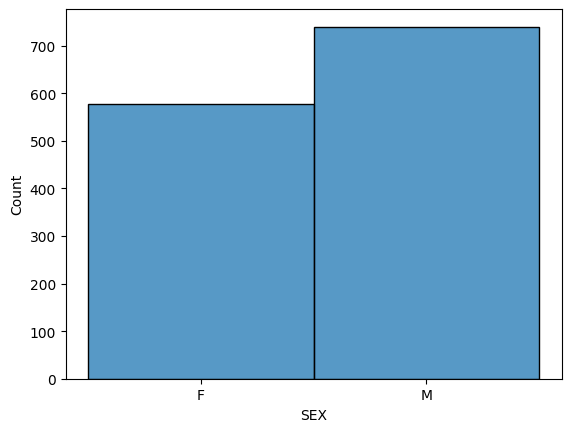

In [4]:
sick = df.loc[df['SOURCE'] == 1]
sns.histplot(sick, x='SEX')
plt.show()

In [5]:
bin_age.pivot_table(index='AGE', columns='SEX')['SOURCE']

SEX,F,M
AGE,,
"(0.902, 10.8]",0.427083,0.247619
"(10.8, 20.6]",0.282609,0.444444
"(20.6, 30.4]",0.275304,0.363265
"(30.4, 40.2]",0.333333,0.293839
"(40.2, 50.0]",0.406699,0.406780
"(50.0, 59.8]",0.435233,0.467181
"(59.8, 69.6]",0.380165,0.508591
"(69.6, 79.4]",0.352941,0.492891
"(79.4, 89.2]",0.421687,0.589041


In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
df = pd.read_csv('training_set.csv')
subs = {
    'M': 1,
    'F': 0
}
df = df.replace(subs)
df['SEX']
y = df['SOURCE']
X = df.drop('SOURCE', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=1/3)

Predizione decision tree Test: 0.6609247506799637 Train: 1.0
Predizione logistic regression Test: 0.7107887579329103 Train: 0.7153218495013599


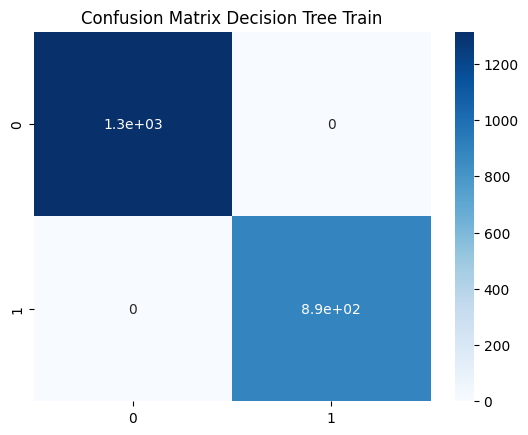

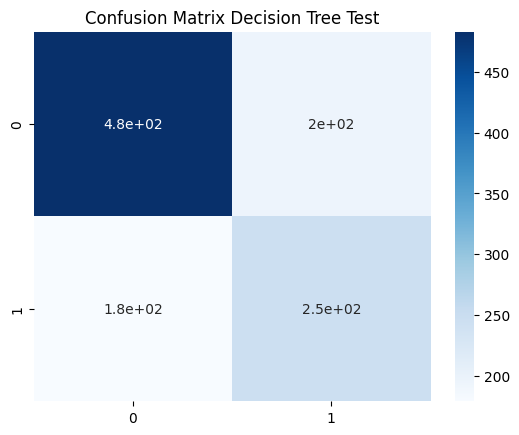

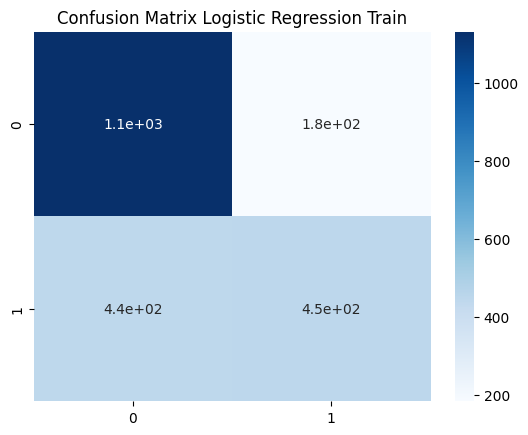

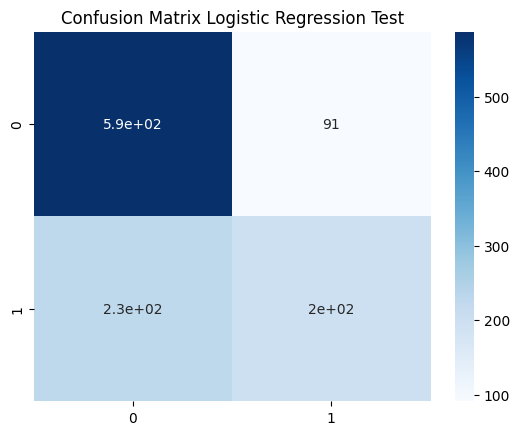

Predizione Dummy Test: 0.6609247506799637 Train: 1.0


In [7]:
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
warnings.filterwarnings('ignore')

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

test_pred = tree.predict(X_test)
train_pred = tree.predict(X_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

test_pred1 = logreg.predict(X_test)
train_pred1 = logreg.predict(X_train)
print(f'Predizione logistic regression Test: {accuracy_score(y_test, test_pred1)} Train: {accuracy_score(y_train, train_pred1)}')
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_pred), annot=True, cmap='Blues')
plt.title('Confusion Matrix Decision Tree Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_pred), annot=True, cmap='Blues')
plt.title('Confusion Matrix Decision Tree Test')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_pred1), annot=True, cmap='Blues')
plt.title('Confusion Matrix Logistic Regression Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_pred1), annot=True, cmap='Blues')
plt.title('Confusion Matrix Logistic Regression Test')
plt.show()

model_dummy = DummyClassifier()
model_dummy.fit(X_train, y_train)

test_pred2 = model_dummy.predict(X_test)
train_pred2 = model_dummy.predict(X_train)
print(f'Predizione Dummy Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

In [8]:
print('Accuracy Decision Tree con Cross Val ',cross_val_score(tree, X, y, cv=10, scoring='accuracy').mean())
print('Accuracy Logistic Regression con Cross Val ',cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())
print('Accuracy Dummy con Cross Val ',cross_val_score(model_dummy, X, y, cv=10, scoring='accuracy').mean())

Accuracy Decision Tree con Cross Val  0.6702874668131465
Accuracy Logistic Regression con Cross Val  0.7144127071317404
Accuracy Dummy con Cross Val  0.6019948732033324


In [9]:
from sklearn.model_selection import GridSearchCV

params = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'min_samples_split' : [2,3,4,5,10]
}
gs = GridSearchCV(tree, params, scoring='accuracy', cv=10, verbose=1)
gs.fit(X_train, y_train)

test_pred = tree.predict(X_test)
train_pred = tree.predict(X_train)
print(gs.best_params_)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

Fitting 10 folds for each of 45 candidates, totalling 450 fits
{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 10}
Predizione decision tree Test: 0.6609247506799637 Train: 1.0


In [10]:
from sklearn.preprocessing import KBinsDiscretizer, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

to_bins = ['AGE', 'THROMBOCYTE']
trasformers = [
    ('KDiscr', KBinsDiscretizer(encode='onehot'), to_bins)
]

ct = ColumnTransformer(trasformers, remainder='passthrough')

my_pip = Pipeline([('discr', ct),
                   ('scaler', MaxAbsScaler()),
                   ('pred', tree)
                   ])

my_pip.fit(X_train,y_train)
print('Accuracy Decision Tree con Cross Val ',cross_val_score(tree, X, y, cv=10, scoring='accuracy').mean())

Accuracy Decision Tree con Cross Val  0.6606170465989198


In [11]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
trasformers = [
    ('KDiscr', KBinsDiscretizer(n_bins=4, encode='onehot'), ['AGE']),
    ('KDiscr1', KBinsDiscretizer(n_bins=10, encode='onehot'), ['THROMBOCYTE'])
]
ct = ColumnTransformer(trasformers, remainder='passthrough')
prepro = Pipeline(steps=[('discr', ct),
                         ('scaler', MinMaxScaler(feature_range=(0,1))),
                         ('norm', Normalizer()),
                         ('model', tree)
                         ])
prepro.fit(X_train,y_train)
print('Accuracy Decision Tree con Cross Val ',cross_val_score(tree, X, y, cv=10, scoring='accuracy').mean())

Accuracy Decision Tree con Cross Val  0.6569962464524398


In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

trasformers = [
    ('KDiscr', KBinsDiscretizer(n_bins=4, encode='onehot'), ['AGE']),
    ('KDiscr1', KBinsDiscretizer(n_bins=10, encode='onehot'), ['THROMBOCYTE'])
]
ct = ColumnTransformer(trasformers, remainder='passthrough')
prepro = Pipeline(steps=[('discr', ct),
                         ('scaler', MinMaxScaler(feature_range=(0,1))),
                         ('norm', Normalizer()),
                         ('pca', PCA(n_components=2)),
                         ('model', tree)
                         ])
prepro.fit(X_train,y_train)
print('Accuracy Decision Tree con Cross Val ',cross_val_score(tree, X, y, cv=10, scoring='accuracy').mean())

prepro1 = Pipeline(steps=[('discr', ct),
                         ('scaler', MinMaxScaler(feature_range=(0,1))),
                         ('norm', Normalizer()),
                         ('kbest', SelectKBest(k=2)),
                         ('model', tree)
                         ])
prepro1.fit(X_train,y_train)
print('Accuracy Decision Tree con Cross Val ',cross_val_score(tree, X, y, cv=10, scoring='accuracy').mean())

Accuracy Decision Tree con Cross Val  0.6678723793829533
Accuracy Decision Tree con Cross Val  0.666060606060606
